In [ ]:
!pip3 install box2d-py
%pip install -U tf-agents pyvirtualdisplay
%pip install -U gym>=0.21.0
%pip install -U gym[box2d,atari,accept-rom-license]


In [ ]:
import matplotlib
import gym
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from itertools import count
from PIL import Image
from google.colab import output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
env = gym.make("ALE/Breakout-v5")


In [ ]:
class DQN(nn.Module):

    def __init__(self, w,h,hidden, outputs):
        super(DQN, self).__init__()
        self.cf1 = nn.Conv2d(3, 8, kernel_size=5, stride=2)
        self.bf1 = nn.BatchNorm2d(8)
        self.cf2 = nn.Conv2d(8, 16, kernel_size=5, stride=2)
        self.bf2 = nn.BatchNorm2d(16)
        def conv_size(size, kernel_size = 5, stride = 2):
            return (size - kernel_size) // stride  + 1
        convw = conv_size(conv_size(w))
        convh = conv_size(conv_size(h))
        inputs = convw * convh * 16
        self.f1 = nn.Linear(inputs, hidden)
        self.f2 = nn.Linear(hidden, outputs)
        self.f3 = nn.Linear(hidden, 1)


    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.bf1(self.cf1(x)))
        x = F.relu(self.bf2(self.cf2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.f1(x))
        
        return self.f3(x) , F.softmax(self.f2(x),dim=1)
  

In [ ]:
class Critic(nn.Module):

    def __init__(self, w,h,hidden, outputs):
        super(Critic, self).__init__()
        self.cf1 = nn.Conv2d(3, 8, kernel_size=5, stride=2)
        self.bf1 = nn.BatchNorm2d(8)
        self.cf2 = nn.Conv2d(8, 16, kernel_size=5, stride=2)
        self.bf2 = nn.BatchNorm2d(16)
        def conv_size(size, kernel_size = 5, stride = 2):
            return (size - kernel_size) // stride  + 1
        convw = conv_size(conv_size(w))
        convh = conv_size(conv_size(h))
        inputs = convw * convh * 16
        self.f1 = nn.Linear(inputs, hidden)
        self.f2 = nn.Linear(hidden, outputs)



    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.bf1(self.cf1(x)))
        x = F.relu(self.bf2(self.cf2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.f1(x))
        return self.f2(x) 

In [ ]:
hidden_layers=32
Learning_rate = 0.001
GAMMA=0.999
resize = T.Compose([T.ToPILImage(),T.Resize(100, interpolation=Image.CUBIC),T.ToTensor()])
state=env.reset()
state= state.transpose((2, 0, 1))
state = np.ascontiguousarray(state, dtype=np.float32) / 255
state = resize(torch.from_numpy(state)).unsqueeze(0)
_, _, h, w = state.shape
agent = DQN(w,h,hidden_layers,env.action_space.n).to(device)
optimizer = optim.Adam(agent.parameters(),lr=Learning_rate)


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [ ]:
EPS_START = 0.9
EPS_END = 0.01
EPS_DECAY = 7000


def select_action(state):
    global steps_done ,eps
    
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    eps.append(eps_threshold)

    action_prob= eps_threshold*np.ones((env.action_space.n,))/env.action_space.n
    _, actions =agent(state)
    #greedy_action=actions.max(1)[1].view(1, 1).item()
    action_probs= torch.distributions.Categorical(probs=actions)
    greedy_action=action_probs.sample().item()
    action_prob[greedy_action] += 1 - eps_threshold
    action_prob = action_prob/np.sum(action_prob)

    return np.random.choice(range(env.action_space.n),p=action_prob)

In [ ]:
def update_network(state, action,reward,next_state,done,t):
  global steps_done , GAMMA
  optimizer.zero_grad()
  state_val, probs = agent(state)
  next_state_val, _ = agent(next_state)
  
  action_probs= torch.distributions.Categorical(probs=probs)
  log_prob = action_probs.log_prob(action)
  theta = reward + GAMMA*next_state_val*(1-int(done)) - state_val
  actor_loss= -1*theta*log_prob
  critic_loss = theta**2
  loss = actor_loss + critic_loss
  
  loss.backward()
  optimizer.step()



In [ ]:
Episodes= 500
rewardPerEpisode=[]
steps_done = 0
eps =[]
timePerEpisode=[]
action_taken=[]
for episode in range(Episodes):
  state=env.reset()
  state= state.transpose((2, 0, 1))
  state = np.ascontiguousarray(state, dtype=np.float32) / 255
  state = resize(torch.from_numpy(state)).unsqueeze(0)
  reward_acc=0
  prev_reward_shaped = 0 
  for t in count():
    
    action = select_action(state)
    action_taken.append
    next_state, reward, done, _ = env.step(action)
    next_state= next_state.transpose((2, 0, 1))
    next_state = np.ascontiguousarray(next_state, dtype=np.float32) / 255
    next_state = resize(torch.from_numpy(next_state)).unsqueeze(0)
    
    reward_acc += reward
    action=torch.tensor([action]).to(device).unsqueeze(0)
    
    state = next_state
    reward=torch.tensor([reward],dtype=torch.float).to(device).unsqueeze(0)
    update_network(state,action,reward,next_state,done,t)
    if done or t>=1000:
      rewardPerEpisode.append(reward_acc)
      timePerEpisode.append(t)
      break
  output.clear()
  print("Episode:",episode, "Reward:",rewardPerEpisode[-1],"Time:",timePerEpisode[-1] )



Episode: 499 Reward: 2.0 Time: 236


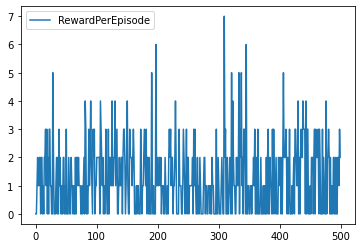

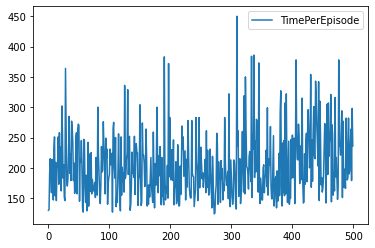

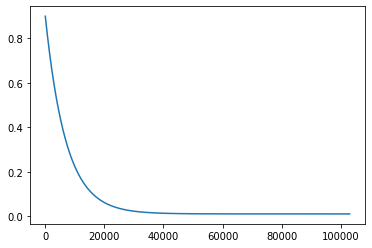

In [ ]:
plt.plot(rewardPerEpisode, label="RewardPerEpisode")
plt.legend()
plt.figure()
plt.plot(timePerEpisode, label= "TimePerEpisode")
plt.legend()
plt.figure()
plt.plot(eps)
plt.show()

In [ ]:
Episodes= 50
rewardPerEpisode1=[]
timePerEpisode1=[]
for episode in range(Episodes):
  state=env.reset()
  state= state.transpose((2, 0, 1))
  state = np.ascontiguousarray(state, dtype=np.float32) / 255
  state = resize(torch.from_numpy(state)).unsqueeze(0)
  reward_acc=0
  for t in count():
    
    action = select_action(state)
    action_taken.append
    next_state, reward, done, _ = env.step(action)
    next_state= next_state.transpose((2, 0, 1))
    next_state = np.ascontiguousarray(next_state, dtype=np.float32) / 255
    next_state = resize(torch.from_numpy(next_state)).unsqueeze(0)
    reward_acc += reward
    state= next_state
    if done or t>=1000:
      rewardPerEpisode1.append(reward_acc)
      timePerEpisode1.append(t)
      break

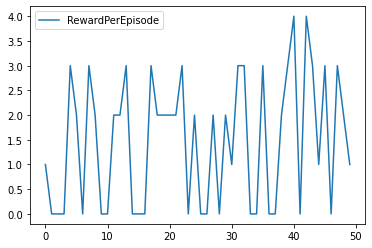

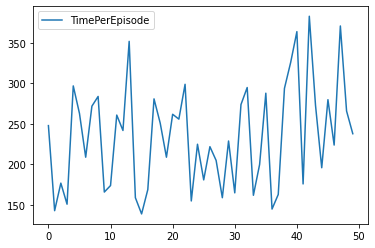

In [ ]:
plt.plot(rewardPerEpisode1, label="RewardPerEpisode")
plt.legend()
plt.figure()
plt.plot(timePerEpisode1, label= "TimePerEpisode")
plt.legend()
plt.show()